In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

## Grab the test data and visualise

In [2]:
data_path = "/home/sravula/experiments/datasets/8047_vel_imgs.npy"

In [3]:
from datasets.velocity_fine import Velocity

tran_transform = transforms.Compose([
    transforms.Resize([256, 256])
])

dataset = Velocity(path=data_path, transform=tran_transform)

In [4]:
N = len(dataset)
indices = list(range(N))
random_state = np.random.get_state()
np.random.seed(2240)
np.random.shuffle(indices)
np.random.set_state(random_state)
train_indices, test_indices = indices[:int(N * 0.9)], indices[int(N * 0.9):]

In [5]:
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=15, shuffle=False,
                         num_workers=8, drop_last=True)

test_iter = iter(test_loader)

test_sample = next(test_iter)[0]

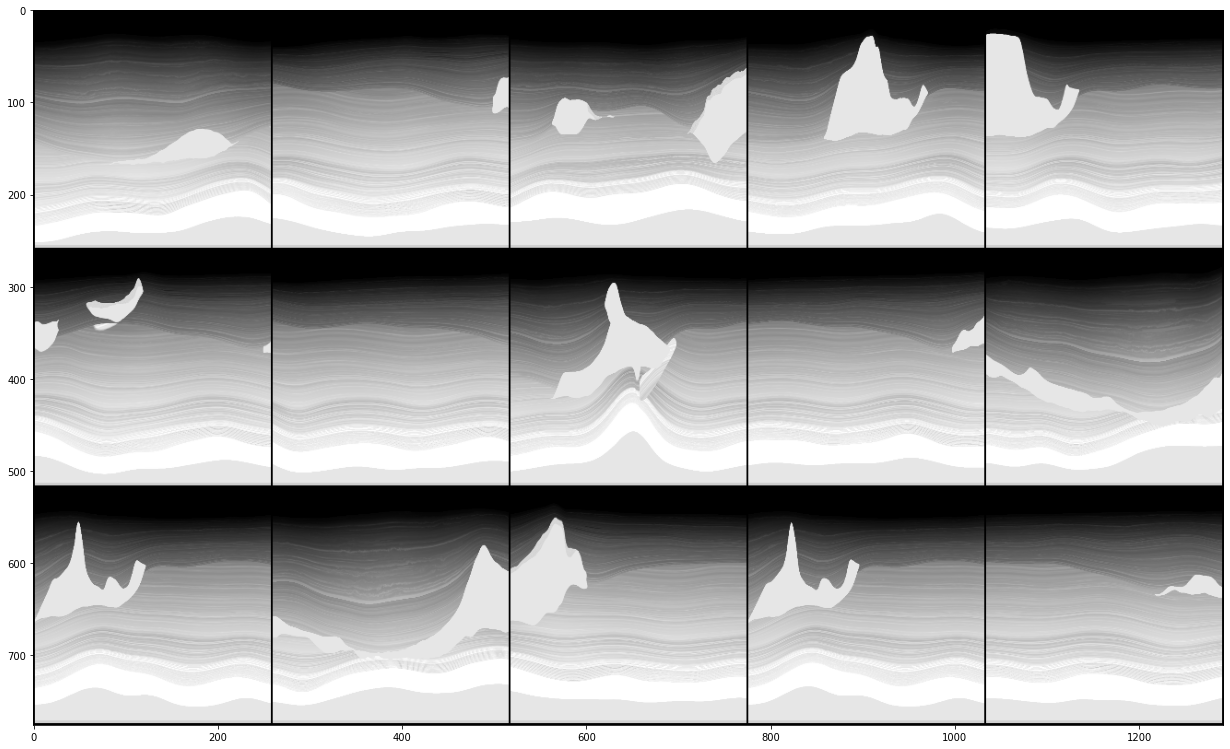

In [7]:
grid_img = torchvision.utils.make_grid(test_sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Noise the test data and visualise

In [8]:
#We want y = Ax where A is a random Gaussian
#y = [N, m, 1], A = [N, m, C x W x H], x = [N, C, H, W]

N, C, H, W = test_sample.shape

m = 1000

In [9]:
A = (1 / m) * torch.randn(m, C*H*W)
y = torch.matmul(A, test_sample.view(N, -1, 1))

print(A.shape)
print(y.shape)
print(test_sample.shape)

torch.Size([1000, 65536])
torch.Size([15, 1000, 1])
torch.Size([15, 1, 256, 256])


## Load the network and perform Langevin dynamics on the noisy images

In [10]:
ckpt_path = "/home/sravula/experiments/logs/run_2/checkpoint.pth"
config_path = "/home/sravula/ncsnv2/configs/velocity.yml"

In [11]:
import argparse
from main import dict2namespace
import yaml

with open(config_path, 'r') as f:
    config = yaml.load(f)
new_config = dict2namespace(config)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
new_config.device = device

print(device)

/home/sravula/venvs/ncsnv2/lib64/python3.6/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


cuda


In [12]:
from models.ncsnv2 import NCSNv2Deepest
from models.ema import EMAHelper
from models import get_sigmas

new_config.input_dim = new_config.data.image_size ** 2 * new_config.data.channels

score = NCSNv2Deepest(new_config).to(new_config.device)
score = torch.nn.DataParallel(score)

#Set up the exponential moving average
if new_config.model.ema:
    ema_helper = EMAHelper(mu=new_config.model.ema_rate)
    ema_helper.register(score)

states = torch.load(ckpt_path)
score.load_state_dict(states[0])
### Make sure we can resume with different eps
states[1]['param_groups'][0]['eps'] = new_config.optim.eps

if new_config.model.ema:
    ema_helper.load_state_dict(states[4])

#grab all L noise levels
sigmas = get_sigmas(new_config)

In [13]:
test_score = ema_helper.ema_copy(score)

test_score.eval()

DataParallel(
  (module): NCSNv2Deepest(
    (act): ELU(alpha=1.0)
    (begin_conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (normalizer): InstanceNorm2dPlus(
      (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (end_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): ModuleList(
      (0): ResidualBlock(
        (non_linearity): ELU(alpha=1.0)
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize2): InstanceNorm2dPlus(
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize1): InstanceNorm2dPlus(
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
      )
      (1): Resid

In [ ]:
from models import langevin_Inverse
import time

N, C, H, W = test_sample.shape
print(N, C, H, W)

y = y.to(new_config.device)

A = A.to(new_config.device)

x0 = torch.rand(N, C, H, W, device=new_config.device)

mse = torch.nn.MSELoss()
mse_start = mse(x0, test_sample.to(new_config.device))
print("Start MSE: ", mse_start.item())

start = time.time()

all_samples = langevin_Inverse(x_mod = x0, 
                                       y = y, 
                                       A = A, 
                                       scorenet = test_score, 
                                       sigmas = sigmas.cpu().numpy(), 
                                       n_steps_each=1,
                                       step_lr=new_config.sampling.step_lr,
                                       final_only=True, 
                                       verbose=True,
                                       denoise=False,
                                       add_noise=False, 
                                       decimate_sigma=1100//50,
                                       mode=None,
                                       true_x=test_sample.to(new_config.device))

print("\nTOTAL TIME: ", time.time() - start)

15 1 256 256
Start MSE:  0.21257354319095612

level: 0, step_size: 90.0000, prior_norm: 3.4046, likelihood_norm: 0.0634, grad_norm: 3.4107                             image_norm: 268.3739, train_mse: 0.0136
true_mse: 0.8654


In [ ]:
sample = all_samples[-1].view(all_samples[-1].shape[0], new_config.data.channels,
                              new_config.data.image_size,
                              new_config.data.image_size)

sample = torch.clamp(sample, 0.0, 1.0)

In [ ]:
grid_img = torchvision.utils.make_grid(sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()